In [6]:
# default_exp transforms
# all_slow

In [7]:
# hide
# ! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
# ! [ -e /content ] && pip install -Uqq albumentations  # upgrade albumentations

In [8]:
# hide
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir("/content/drive/MyDrive/Colab Notebooks/severstal")

# Transforms

> Fastai Transforms API to Severstal dataset.

In [9]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
# export
from fastai.vision.all import *
import os
import pandas as pd
import numpy as np
import torch

from steel_segmentation.utils import rle2mask, mask2rle, get_train_df, get_train_pivot

The `fastai` data block API cannot give us a tuple (`input`,`target`) data for our Deep Learning model.
That's why we need to create custom `Transform`s to fix this problem and leverage anyway the high level framework.

In [11]:
path = Path("../data")
assert path.is_dir()

In [12]:
train_df = get_train_df(path, only_faulty=True)
train_pivot = get_train_pivot(train_df)
train_pivot.shape

(6578, 5)

In [13]:
train_example = train_pivot.sample().iloc[0]
train_example.name

'b1933b386.jpg'

## Get_x transform

In [14]:
# export
class ReadImagePathFromIndex(Transform):
    """Read image name from `train_pivot` and returns the image path"""
    def __init__(self, pref):
        self.pref = str(pref) + os.path.sep if isinstance(pref, Path) else pref

    def encodes(self, row:pd.Series, **kwargs):
        o = row.name # ImageId
        return f'{self.pref}{o}'     

With the `ReadImagePathFromIndex` transform we can get the first information of the training example, the image path for `train_example` from `train_pivot`.
In setup we need to specify the prefix to be added to the `ImageId` of the training image.

In [15]:
x_tfm = ReadImagePathFromIndex(pref=(path/"train_images"))

In [16]:
x = x_tfm(train_example)
test_eq(x, str(path/"train_images"/train_example.name))

## Get_y transform

In [17]:
# export
class ReadRLEs(Transform):
    """Read RLEs from `train_pivot` and return a list or RLEs."""
    def __init__(self, cols=[1,2,3,4]):
        self.cols = L(cols)

    def encodes(self, row:pd.Series, **kwargs):
        return [row[i] if not row[i] is np.nan else ''
                for i in self.cols]

With the `ReadRLEs` transform we can get our labels, the list of RLEs (one for each `ClassId`s).
In the setup we need to specify the column names of the `ClassId`.
In input we pass the `train_example` and we get a list of strings as output.

In [18]:
cols = [1,2,3,4]
y_tfm = ReadRLEs(cols=cols)
rles = y_tfm(train_example)
test_eq(len(rles), 4)
test_eq(rles, [train_example[i] if not train_example[i] is np.nan else '' for i in cols])

## Get Mask from RLEs

In [19]:
# export
class MakeMask(Transform):
    """Read RLEs list and return a np.array of the mask"""
    h, w = (256, 1600)

    def __init__(self, flatten=True):
        self.flatten = flatten

    def encodes(self, o:list, **kwargs):
        mask = np.zeros((self.h, self.w, 4), dtype=np.float32) # 4:class 1～4 (ch:0～3)

        for i in range(4):
            rle = o[i]
            if rle != '':
                mask[:, :, i] = rle2mask(rle=rle, value=1, shape=(self.h,self.w))

        if self.flatten:
            classes = np.array(range(1,5))
            return (mask * classes).sum(-1)

        return mask

    def decodes(self, mask, **kwargs):
        mask = (mask * np.array(range(1,5))).sum(-1) if len(mask.shape) == 3 else mask
        return [mask2rle(np.where(mask==c, mask, 0)) for c in range(1,5)]

The `MakeMask` transform needs a list of RLEs and returns a mask with `(256, 1600)` shape if `flatten` is `True` (default). If `flatten` is `False`  returns a `(256, 1600, 4)` array.

In [20]:
mask_tfm = MakeMask(flatten=False)
mask = mask_tfm(rles)
test_eq(mask.shape, (256,1600,4))
# Default transform with flatten mask for PILMask.create
flatten_mask_tfm = MakeMask()
flatten_mask = flatten_mask_tfm(rles)
test_eq(flatten_mask.shape, (256,1600))

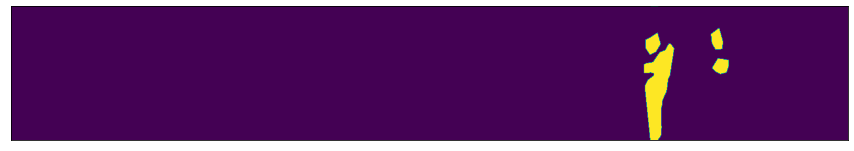

In [21]:
plt.figure(figsize=(15,5))
plt.xticks([])
plt.yticks([])
plt.imshow(flatten_mask);

In [23]:
rle = mask_tfm.decode(mask)
test_eq(rle, rles)
flatten_rle = flatten_mask_tfm.decode(flatten_mask)
test_eq(flatten_rle, rles)

Finally, a `Datasets` object can be built from the two `Pipeline`s created with the previous transforms.

In [24]:
x_tfms = Pipeline([x_tfm, PILImage.create])
y_tfms = Pipeline([y_tfm, flatten_mask_tfm, PILMask.create])
dsets = Datasets(train_pivot, [x_tfms, y_tfms])
elem = dsets.train[1]
image, mask = elem
type(elem), image, mask

(tuple, PILImage mode=RGB size=1600x256, PILMask mode=F size=1600x256)

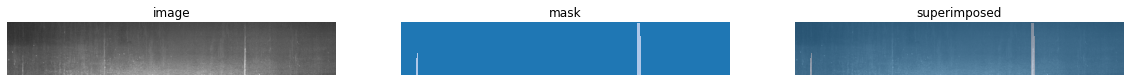

In [25]:
_,axs = plt.subplots(1,3, figsize=(20, 5))
image.show(ctx=axs[0], title='image')

mask.show(alpha=1, ctx=axs[1], vmin=1, vmax=30, title='mask')

image.show(ctx=axs[2], title='superimposed')
mask.show(ctx=axs[2], vmin=1, vmax=30);

## Get a 4-channel Mask

In [26]:
# export
class ChannelMask(Transform):
    """Transform (x,y) tensor masks from [w, h] to [channels, w, h]"""
    order=9

    def create_mask(self, mask):
        new_mask = torch.zeros(4, mask.shape[0], mask.shape[1])
        for i in range(4):
            new_mask[i] = torch.where(mask==(i+1), 1, 0)
        return new_mask

    def decode_mask(self, mask, classes):
        # tensorboard log images bug in TensorBoardCallback after_epoch
        if mask.device != classes.device:
            mask = mask.to(classes.device)
        return (mask * classes).sum(0)

    def encodes(self, o:TensorMask):
        if o.dim() == 2: return self.create_mask(o)
        elif o.dim() == 3:
            new_batch = []
            for mask in o: new_batch.append(self.create_mask(mask))
            return torch.stack(new_batch, axis=0)
        else: return o

    def decodes(self, o:TensorMask):
        classes = torch.tensor(range(1,5)).unsqueeze(-1).unsqueeze(-1)
        if o.dim() == 3: return self.decode_mask(o, classes)
        elif o.dim() == 4:
            new_masks = []
            for mask in o:
                new_masks.append(self.decode_mask(mask, classes))
            return torch.stack(new_masks, axis=0)
        else: return o

The `ChannelMask` transform changes the shape of the mask from a flatten `(256, 1600)` to `(4, 256, 1600)`.

In [27]:
tens = ToTensor()
timg, tmask = tens(elem)
timg.shape, tmask.shape

(torch.Size([3, 256, 1600]), torch.Size([256, 1600]))

In [28]:
tfm = ChannelMask()
ch_mask = tfm(tmask)
ch_mask.shape

torch.Size([4, 256, 1600])

In [29]:
decoded_mask = tfm.decodes(ch_mask)
decoded_mask.shape

torch.Size([256, 1600])

In [30]:
test_close(decoded_mask, tmask)

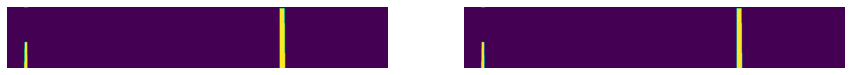

In [31]:
show_images((decoded_mask,tmask), figsize=(15,5));

## Albumentation transforms

In [32]:
img, mask = elem
img, mask = np.array(img), np.array(mask)
img.shape, mask.shape

((256, 1600, 3), (256, 1600))

Some augmentations from the `albumentation` library:

In [33]:
import albumentations as alb
import cv2

def show_aug(aug, img, mask):
    aug_elem = aug(image=img, mask=mask)
    aug_crop_img = aug_elem["image"]
    aug_crop_mask = aug_elem["mask"]
    print(aug_crop_img.shape, aug_crop_mask.shape)
    print(f"Unique elems in mask: {np.unique(aug_crop_mask)}")
    show_images((aug_crop_img, aug_crop_mask), figsize=(10,20))
    return aug_crop_img, aug_crop_mask

(256, 400, 3) (256, 400)
Unique elems in mask: [0. 3.]


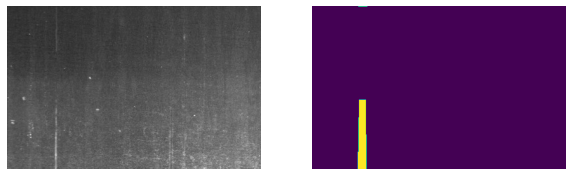

In [34]:
aug = alb.CropNonEmptyMaskIfExists(256, 400, p=1., ignore_values=[0])
aug_crop_img, aug_crop_mask = show_aug(aug, img, mask)

(256, 400, 3) (256, 400)
Unique elems in mask: [0. 3.]


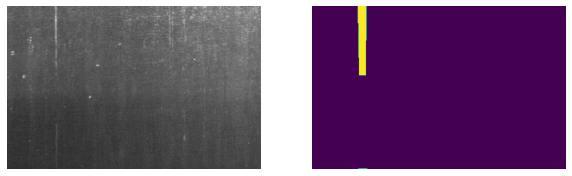

In [35]:
aug = alb.VerticalFlip(p=1.)
aug_img, aug_mask = show_aug(aug, aug_crop_img, aug_crop_mask)

(256, 400, 3) (256, 400)
Unique elems in mask: [0. 3.]


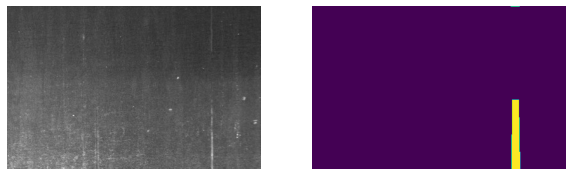

In [36]:
aug = alb.HorizontalFlip(p=1.)
aug_img, aug_mask = show_aug(aug, aug_crop_img, aug_crop_mask)

(256, 400, 3) (256, 400)
Unique elems in mask: [0. 3.]


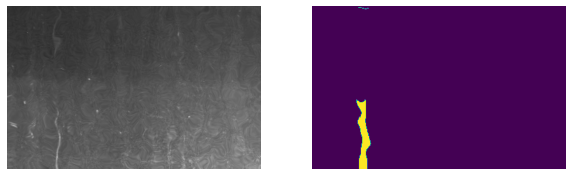

In [37]:
aug = alb.ElasticTransform(p=1., alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
aug_img, aug_mask = show_aug(aug, aug_crop_img, aug_crop_mask)

(256, 400, 3) (256, 400)
Unique elems in mask: [0. 3.]


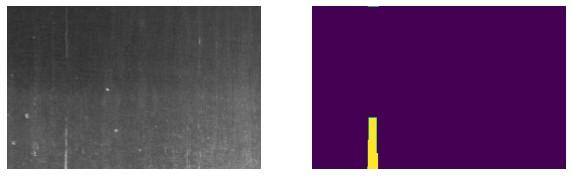

In [38]:
aug = alb.GridDistortion(p=1.)
aug_img, aug_mask = show_aug(aug, aug_crop_img, aug_crop_mask)

(256, 400, 3) (256, 400)
Unique elems in mask: [0. 3.]


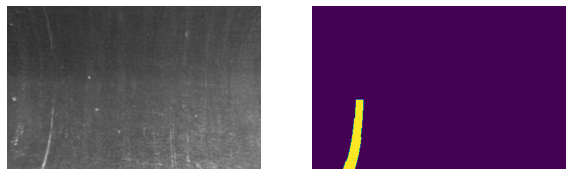

In [39]:
aug = alb.OpticalDistortion(distort_limit=0.5, shift_limit=0.05, p=1., border_mode=cv2.BORDER_REPLICATE)
aug_img, aug_mask = show_aug(aug, aug_crop_img, aug_crop_mask)

In [40]:
HEIGHT, WIDTH = (224, 400)

def get_train_aug(): 
    tfm_list = [
      alb.RandomCrop(HEIGHT, WIDTH, p=1.0),
      #alb.Resize(128, 800),
      alb.OneOf(
          [
           alb.VerticalFlip(p=0.5),
           alb.HorizontalFlip(p=0.5),
          ], p=0.6),
      alb.OneOf(
          [
           alb.RandomBrightnessContrast(
               brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
           alb.RandomGridShuffle(grid=(1, 2), p=0.2),
          ], p=0.6),
    ]
    return alb.Compose(tfm_list)

def get_valid_aug(): 
    tfms = [alb.RandomCrop(HEIGHT, WIDTH)]
    return alb.Compose(tfms)

In [41]:
# export
class AlbumentationsTransform(ItemTransform, RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): 
        self.train_aug, self.valid_aug = train_aug, valid_aug

    def before_call(self, b, split_idx):
        self.idx = split_idx

    def encodes(self, o):
        img, mask = o
        if self.idx == 0:
            aug = self.train_aug(image=np.array(img),mask=np.array(mask))
            aug_img = aug['image']
            aug_mask = aug['mask']
        else:
            aug = self.valid_aug(image=np.array(img),mask=np.array(mask))
            aug_img = aug['image']
            aug_mask = aug['mask']
        return PILImage.create(aug_img), PILMask.create(aug_mask)

(224, 400, 3) (224, 400)
Unique elems in mask: [0. 3.]


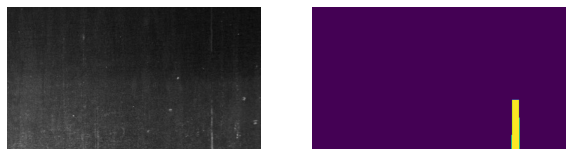

In [42]:
train_aug = get_train_aug()
aug_img, aug_mask = show_aug(train_aug, aug_crop_img, aug_crop_mask)

(224, 400, 3) (224, 400)
Unique elems in mask: [0. 3.]


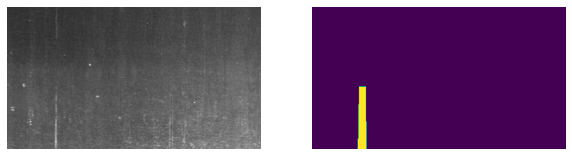

In [43]:
valid_aug = get_valid_aug()
aug_img, aug_mask = show_aug(valid_aug, aug_crop_img, aug_crop_mask)

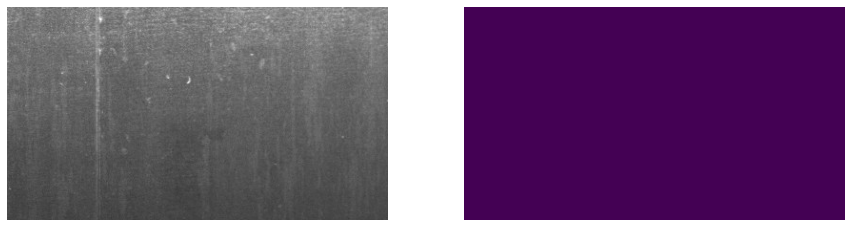

In [44]:
alb_tfm = AlbumentationsTransform(train_aug, valid_aug)
alb_aug_elem = alb_tfm(elem, split_idx=0)
show_images(alb_aug_elem, figsize=(15, 10))

## SteelMask Block

In [45]:
# export
def SteelMaskBlock():
    tfm_mask = MakeMask()
    tfm_addCodes = AddMaskCodes([1,2,3,4])
    tfm_block = TransformBlock(
        type_tfms=[tfm_mask, PILMask.create],
        item_tfms=[tfm_addCodes]
    )
    return tfm_block

In [46]:
itfms = [alb_tfm]
block = DataBlock(
    blocks = (ImageBlock, SteelMaskBlock()),
    get_x = x_tfm,
    get_y = y_tfm,
    splitter = TrainTestSplitter(),
    item_tfms = itfms
)
block.summary(train_pivot)

Setting-up type transforms pipelines
ImageId                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
0002cc93b.jpg  29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 

C:\Users\beanTech\miniconda3\envs\steel_segmentation\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


## Export

In [47]:
# hide
from nbdev.export import notebook2script
notebook2script()

ModuleNotFoundError: No module named 'nbdev'